# Advanced Models

### Setup & Current Results

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import sys
sys.path.append('../')

from src.preprocessing import preprocess_data

print("=" * 80)
print("CURRENT RESULTS")
print("=" * 80)
print("03_modeling.ipynb        - Ridge Baseline:          RMSE 0.1527, R² 0.8617")
print("04_feature_engineering   - Ridge + Features:        RMSE 0.1439, R² 0.8772")
print("=" * 80)
print("Goal: Even better Scores with Gradient Boosting!")
print("=" * 80)

CURRENT RESULTS
03_modeling.ipynb        - Ridge Baseline:          RMSE 0.1527, R² 0.8617
04_feature_engineering   - Ridge + Features:        RMSE 0.1439, R² 0.8772
Goal: Even better Scores with Gradient Boosting!


### Prepare Data

In [10]:
# Loading and preprocessing Data
train = pd.read_csv('../data/train.csv')

train_processed, y_log, train_ids = preprocess_data(
    train, remove_outliers_flag=True
)

# Feature Engineering (from the notebook before)
def create_additional_features(df):
    df = df.copy()
    
    # 1. Total Square Footage
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # 2. Total Bathrooms
    df['TotalBath'] = (df['FullBath'] + 0.5 * df['HalfBath'] + 
                       df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'])
    
    # 3. Total Porch SF
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['EnclosedPorch'] + 
                          df['3SsnPorch'] + df['ScreenPorch'])
    
    # 4. House Age
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    
    # 5. Is Remodeled
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    
    # 6. Quality Interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    
    # 7. Binary Features
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    # 8. Total Quality
    df['TotalQuality'] = df['OverallQual'] + df['OverallCond']
    
    # 9. Lot Ratio
    df['LotArea_per_GrLivArea'] = df['LotArea'] / (df['GrLivArea'] + 1)
    
    # 10. Garage Score
    if 'GarageQual' in df.columns and 'GarageCond' in df.columns:
        df['GarageScore'] = df['GarageQual'] + df['GarageCond']
    
    # 11. Kitchen Ratio
    df['KitchenPerRoom'] = df['KitchenAbvGr'] / (df['TotRmsAbvGrd'] + 1)
    
    return df

train_with_features = create_additional_features(train_processed)

# One-Hot Encoding
categorical_features = train_with_features.select_dtypes(include=['object']).columns
train_encoded = pd.get_dummies(train_with_features, columns=categorical_features, drop_first=True)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(
    train_encoded, y_log, test_size=0.2, random_state=42
)

print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")

Start Preprocessing...
Deleted: 2 Outliers

1. Handeling Missing Values...
Missing Values handeled. Remaining NAs: 0

2. Encoding Ordinal Features...

Preprocessing Done!
Training Shape: (1458, 79)
Training: (1166, 228)
Validation: (292, 228)


C:\Users\Anwender\AppData\Local\Temp\ipykernel_22620\2999552791.py:59: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = train_with_features.select_dtypes(include=['object']).columns


### XGBoost Model

In [11]:
print("=" * 60)
print("XGBOOST")
print("=" * 60)

# XGBoost - without early stopping (easier!)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,  # Fixed
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.001,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# Metrics
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"Training RMSE:   {train_rmse_xgb:.4f}")
print(f"Validation RMSE: {val_rmse_xgb:.4f}")
print(f"R² Score:        {r2_xgb:.4f}")
print("=" * 60)

XGBOOST
Training XGBoost...
Training RMSE:   0.0183
Validation RMSE: 0.1342
R² Score:        0.8932


### LightGBM Model

In [12]:
print("=" * 60)
print("LIGHTGBM")
print("=" * 60)

# LightGBM with optimized Hyperparameters
lgb_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=4,
    num_leaves=20,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Training
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train)
y_val_pred_lgb = lgb_model.predict(X_val)

# Metrics
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
val_rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
r2_lgb = r2_score(y_val, y_val_pred_lgb)

print(f"Training RMSE:   {train_rmse_lgb:.4f}")
print(f"Validation RMSE: {val_rmse_lgb:.4f}")
print(f"R² Score:        {r2_lgb:.4f}")
print(f"Best Iteration:  {lgb_model.best_iteration_}")
print("=" * 60)

LIGHTGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[537]	training's l2: 0.00405462	valid_1's l2: 0.0181478
Training RMSE:   0.0637
Validation RMSE: 0.1347
R² Score:        0.8924
Best Iteration:  537


### Model Comparison


FULL MODEL COMPARISON
                     Notebook            Model  Validation RMSE  R² Score
 05_advanced_models (XGBoost)          XGBoost         0.134161  0.893244
05_advanced_models (LightGBM)         LightGBM         0.134714  0.892363
       04_feature_engineering Ridge + Features         0.143900  0.877200
                  03_modeling Ridge (Baseline)         0.152700  0.861700


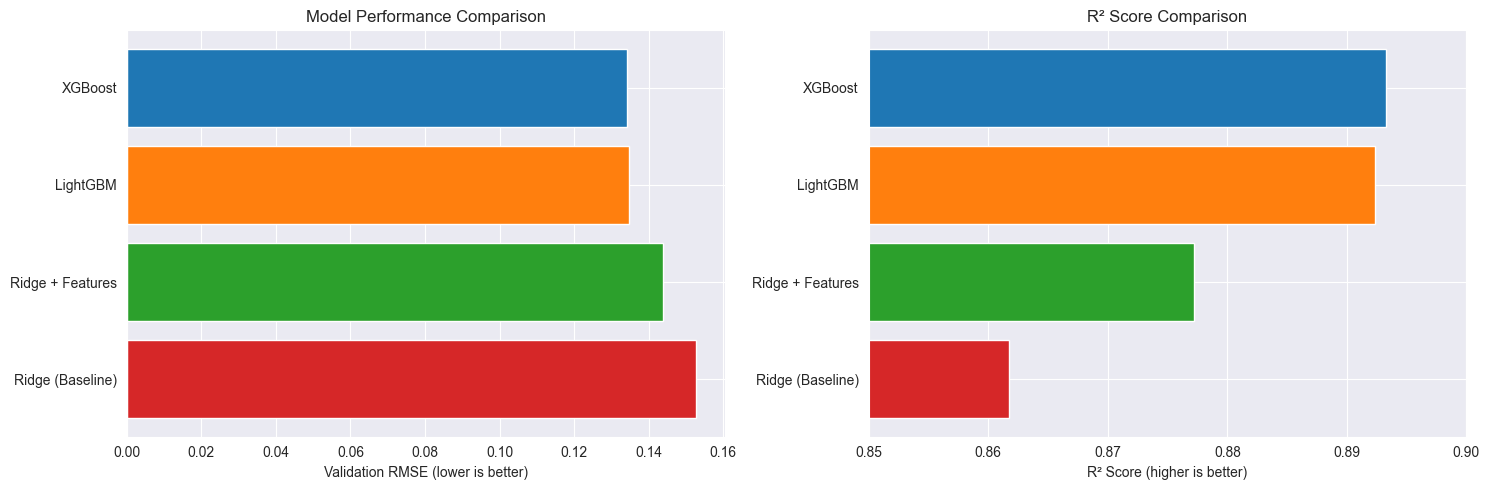

In [13]:
# Summarize all results
results = pd.DataFrame({
    'Notebook': [
        '03_modeling',
        '04_feature_engineering',
        '05_advanced_models (XGBoost)',
        '05_advanced_models (LightGBM)'
    ],
    'Model': [
        'Ridge (Baseline)',
        'Ridge + Features',
        'XGBoost',
        'LightGBM'
    ],
    'Validation RMSE': [
        0.1527,
        0.1439,
        val_rmse_xgb,
        val_rmse_lgb
    ],
    'R² Score': [
        0.8617,
        0.8772,
        r2_xgb,
        r2_lgb
    ]
}).sort_values('Validation RMSE')

print("\n" + "=" * 80)
print("FULL MODEL COMPARISON")
print("=" * 80)
print(results.to_string(index=False))
print("=" * 80)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE
axes[0].barh(results['Model'], results['Validation RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_xlabel('Validation RMSE (lower is better)')
axes[0].set_title('Model Performance Comparison')
axes[0].invert_yaxis()

# R²
axes[1].barh(results['Model'], results['R² Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_xlabel('R² Score (higher is better)')
axes[1].set_title('R² Score Comparison')
axes[1].set_xlim([0.85, 0.90])
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Feature Importance (XGBoost)


Top 20 most important Features (XGBoost):
                   Feature  Importance
57     OverallQual_TotalSF    0.195984
58   OverallQual_GrLivArea    0.105981
192           CentralAir_Y    0.050694
36              GarageCars    0.047966
71             MSZoning_RM    0.041366
66             GarageScore    0.032761
51                 TotalSF    0.032031
30             KitchenQual    0.031797
8                ExterQual    0.029651
35            GarageFinish    0.021810
10                BsmtQual    0.020785
52               TotalBath    0.018352
160     Exterior1st_Stucco    0.015917
210           PavedDrive_Y    0.014584
64            TotalQuality    0.013980
104   Neighborhood_OldTown    0.013849
70             MSZoning_RL    0.013145
33             FireplaceQu    0.011450
22            LowQualFinSF    0.010203
32              Fireplaces    0.009042


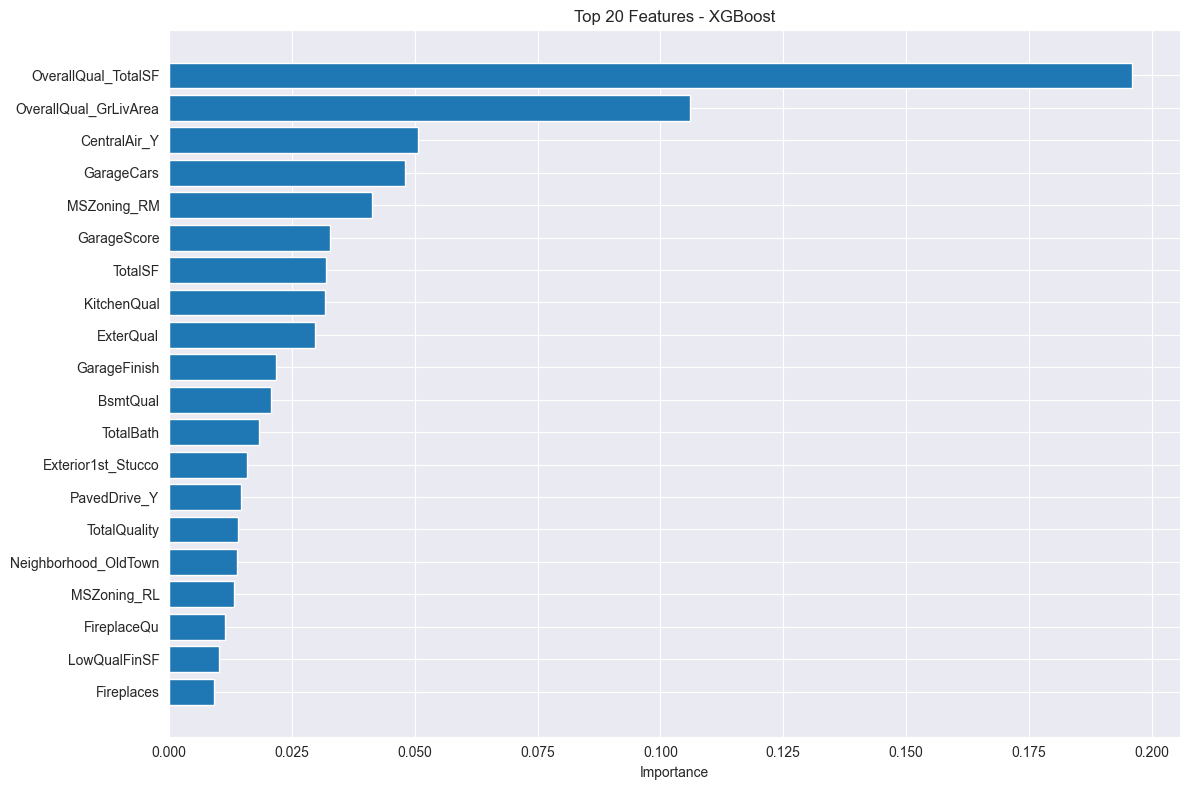

In [14]:
# XGBoost Feature Importance
feature_imp_xgb = pd.DataFrame({
    'Feature': train_encoded.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 most important Features (XGBoost):")
print(feature_imp_xgb.head(20))

# Plot
plt.figure(figsize=(12, 8))
top_20 = feature_imp_xgb.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()